# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [6]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plot
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

# Funções de Ativação

In [3]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [4]:
def softmax(x, y_oh=None, derivative=False):
    if derivative:
        y_pred = softmax(x)
        k = np.nonzero(y_pred * y_oh)
        pk = y_pred[k]
        y_pred[k] = pk * (1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp / np.sum(exp, axis=1, keepdims=True)

# Funções de Custo

###### Para Regressão

In [5]:
#MAE - mean of absolute errors - media dos erros absolutos
def mae(y, y_pred, derivative = False):
    cost = np.mean(np.abs(y-y_pred))
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return cost

# MSE - mean of square errors - média dos erros quadrados
def mse(y, y_pred, derivative = False):
    cost = 0.5 * np.mean((y - y_pred)**2)
    if derivative:
        return -(y - y_pred) * 1.0 / y.shape[0]
    return cost

###### Para Classificação Binária

In [6]:
def binary_cross_entropy(y, y_pred, derivative = False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid)/y.shape[0]
    return -np.mean(y * np.log(y_sigmoid) + (1 - y) * np.log(1 - y_sigmoid)) 
    
    

###### Para Classificação Multiclasse

In [7]:
def neg_log_likelihood(y_oh, y_pred, derivative=False):
    k = np.nonzero(y_pred * y_oh)
    pk = y_pred[k]
    if derivative:
        y_pred[k] = (-1.0 / pk)
        return y_pred
    return np.mean(-np.log(pk))

def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    if derivative:
        return -(y_oh - y_softmax) / y_oh.shape[0]    
    return neg_log_likelihood(y_oh, y_softmax)

# Inicialização de Pesos

In [8]:
# O numero de linhas(rows) será a quantidade de neuronio da camada atual e o numero de colunas(cols) 
# será o numero de neuronios da camada anterior
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    std_dev = np.sqrt(2.0/(rows+cols))
    return std_dev * np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    limit = np.sqrt(6.0/(rows+cols))
    return 2 * limit * np.random.rand(rows, cols) - limit

# Regularização

In [9]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w <  0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    # weights - array de pesos de todas as camadas
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [16]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size #divisão inteira
    
    for batch in range(n_batches):
        offset = batch * batch
        x_batch, y_batch = x [offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [3]:
def none_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1.0+ decay_rate * epoch)

def exponencial_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** epoch

def stair_case(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate ** (epoch // decay_steps)

# Batch Normalization 

# Implementação 

In [4]:
class Layer():
    #O que uma camada deve ter no seu construtor?
    # dimensão de entrada
    # dimensão de saida
    # Qual a função de ativação dela    
    def __init__(self, input_dim, output_dim, weights_initializer=random_normal, biases_initializer=ones, activation=linear, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob # Array do mesmo tamanho dos neuronios daquela camada onde 0 apagou e 1 manteve
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        
        # Esses valores abaixo serão usados no backpropagation e 
        # são calculados no feedforward, que é
        # Entrada da função de ativação de cada camada: _activ_inp
        # saída da função de ativação de cada camada: _activ_out     
        self._activ_inp, self._activ_out = None, None
        
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None

class NeuralNetwork():
    # Atenção que a learning rate é um parametro da rede!
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, momentum=0.0): 
        self.layers = [] # objeto da classe layer
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        
    #Toda rede deve ter pelo menos dois metodos: fit e predict
    
    # Metodo para aprender com os dados
    def fit(self, x_train, y_train, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        for epoch in range(epochs + 1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)
            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                
    # o Medodo fit tem que ter basicamente só duas coisas.
    # Calcular a saida da rede (y_pred) :
                y_pred = self.__feedforward(x_batch)
    # Fazer o backpropagation(derivadas, atualizar pesos, bias, etc)
                self.__backprop(y_batch, y_pred)
            
            if epoch % verbose == 0:
            # Aqui chama o predict em x_train ao inves de y_pred, pois a chamada aqui é
            # o predict, que executa o feedforward com o xtrain. Isso porque depois que 
            # chamou a backprop, os pesos já foram atualizados. Se colocasse o y_pred,
            # os pesos não teriam sido atualizados ainda.
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0 / y_train.shape[0]) * np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print(f"Epoch: {epoch:=4}/{epochs} - loss_train: {loss_train:.8f}")
                
    
    # Metodo para fazer as predicoes
    def predict(self, x):
        return self.__feedforward(x, is_training=False)
    
    #Esses metodos não precisam ficar "acessiveis"
    def __feedforward(self, x, is_training=True):
    # Lembrando que sempre é feito duas coisas:
    # Calcula a entrada da funcao de ativação ( multiplica a entrada com os pesos e 
    # soma o bias).
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0,0)]):
    #Esse [Layer(0,0)] foi adicionado ao ultimo vetor somente para o zip nao parar, pois
    # seria o menor vector (inicia ja uma posição adiante que representa o next_layer). 
    # Assim adiciona-se uma ultima camada
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            # Usa a distribuicao binomial
            current_layer._dropout_mask = np.random.binomial(1, 1.0 - current_layer.dropout_prob, y.shape) /(1.0 - current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out  = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    
    # E depois passa para a função de ativação
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0 * dactivation.sum(axis=0, keepdims=True)
            
        for layer in reversed(self.layers):
            layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative = True)
            layer._prev_dweights = -self.learning_rate * layer._dweights + self.momentum * layer._prev_dweights
            layer.weights = layer.weights + layer._prev_dweights
            layer.biases = layer.biases - self.learning_rate * layer._dbiases
        

NameError: name 'random_normal' is not defined

## Exemplos do Notebook da Intuição

### Exemplo 1

In [39]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) 
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]])

# insira sua rede aqui!
input_dim, output_dim = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose = 1)
for layer in nn.layers:
    print(layer.weights)


Epoch:    0/0 - loss_train: 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [40]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

# insira sua rede aqui!

input_dim = x.shape[0]
output_dim = y.shape[0]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=output_dim, activation=linear))

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2
nn.layers[2].weights = w3
nn.layers[2].biases = b3


nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)








Epoch:    0/300 - loss_train: 1.14054966
Epoch:   30/300 - loss_train: 0.59630022
Epoch:   60/300 - loss_train: 0.36031189
Epoch:   90/300 - loss_train: 0.24668884
Epoch:  120/300 - loss_train: 0.18386202
Epoch:  150/300 - loss_train: 0.14510157
Epoch:  180/300 - loss_train: 0.11918285
Epoch:  210/300 - loss_train: 0.10078511
Epoch:  240/300 - loss_train: 0.08712037
Epoch:  270/300 - loss_train: 0.07660623
Epoch:  300/300 - loss_train: 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.30086971 0.20173942 0.70608796]
 [0.40145052 0.30290104 0.91015363]]
[[0.20544723 0.30673159 0.50749567]
 [0.30994562 0.5123005  0.71366784]
 [0.61065514 0.41317913 0.81464085]]
[[ 0.66465527  0.98758148  1.39393956]
 [ 0.05020341  0.44006253 -0.06274803]
 [ 0.18514132 -0.12764401  0.56880846]]


## Gradient Checking

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

(100, 2)
(100, 1) (100, 1)


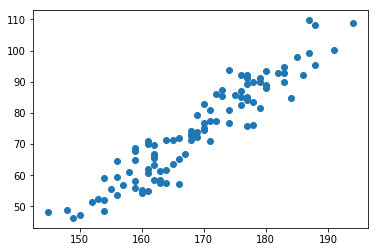

In [57]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)
plt.scatter(x, y)

-1.0 0.9999999999999991


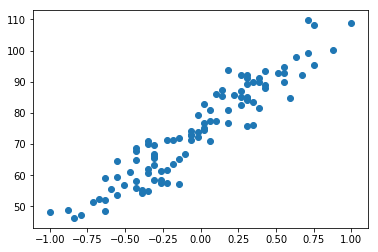

In [58]:
# Normalizando de -1 a 1 ( as alturas somente)
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))
print(x.min(), x.max())
plt.scatter(x, y)

Epoch:    0/1000 - loss_train: 2392.97488841
Epoch:  100/1000 - loss_train: 15.57345485
Epoch:  200/1000 - loss_train: 13.09962174
Epoch:  300/1000 - loss_train: 13.04279338
Epoch:  400/1000 - loss_train: 13.04148793
Epoch:  500/1000 - loss_train: 13.04145795
Epoch:  600/1000 - loss_train: 13.04145726
Epoch:  700/1000 - loss_train: 13.04145724
Epoch:  800/1000 - loss_train: 13.04145724
Epoch:  900/1000 - loss_train: 13.04145724
Epoch: 1000/1000 - loss_train: 13.04145724
[[33.60164745]]
[[74.99636286]]


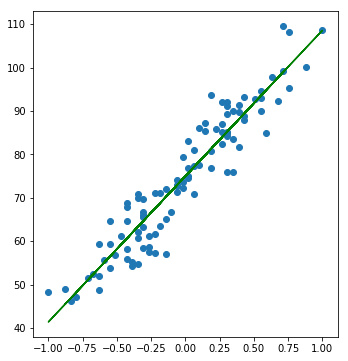

In [66]:
from random import random
input_dim, output_dim = x.shape[1], y.shape[1]


#Arnaldo queria usando as classes
#w = [2 * random() -1 for i in range(input_dim)]
#b = 2 * random() -1
#learning_rate = 1e-3
#print(w, b)
#for step in range(10001):
#    cost = 0
#    for x_n, y_n in zip(x,y):
#        y_pred = sum([x_i * w_i for x_i, w_i in zip(x_n,w)]) + b
#        error = y_n - y_pred
#        w = [w_i + learning_rate * error * x_i for x_i, w_i in zip(x_n,w)]
#        b = b + learning_rate * error
#        cost += error**2
#        #print(error)
#    if step % 1000 == 0:
#        print(f"Step: {step} - Cost: {cost}")
        

#print(f"w: {w}")
#print(f"b: {b}") 


# insira sua rede aqui!

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [69]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [71]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))


[-1. -1. -1.] [1. 1. 1.]


In [76]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim = input_dim, output_dim=output_dim, activation=linear))

nn.fit(x,y, epochs=2000, verbose=200)
print(nn.layers[0].weights)
print(nn.layers[0].biases)

#plt.scatter(x, y)

Epoch:    0/2000 - loss_train: 10079.92254671
Epoch:  200/2000 - loss_train: 6.45374218
Epoch:  400/2000 - loss_train: 3.88537127
Epoch:  600/2000 - loss_train: 3.18984055
Epoch:  800/2000 - loss_train: 2.98178741
Epoch: 1000/2000 - loss_train: 2.91227100
Epoch: 1200/2000 - loss_train: 2.88660674
Epoch: 1400/2000 - loss_train: 2.87640185
Epoch: 1600/2000 - loss_train: 2.87214612
Epoch: 1800/2000 - loss_train: 2.87032152
Epoch: 2000/2000 - loss_train: 2.86952727
[[ 8.91974113 13.9880089  26.18124664]]
[[150.63920806]]


### Regressão Quadrática

(100, 1) (100, 1)


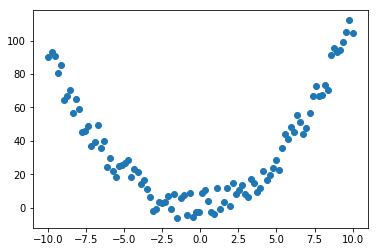

In [11]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [12]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 - loss_train: 1072.32744196
Epoch:  500/5000 - loss_train: 506.93640342
Epoch: 1000/5000 - loss_train: 40.55294174
Epoch: 1500/5000 - loss_train: 24.30909102
Epoch: 2000/5000 - loss_train: 20.00620256
Epoch: 2500/5000 - loss_train: 18.27267567
Epoch: 3000/5000 - loss_train: 17.13261729
Epoch: 3500/5000 - loss_train: 16.22601078
Epoch: 4000/5000 - loss_train: 15.38826132
Epoch: 4500/5000 - loss_train: 15.09571061
Epoch: 5000/5000 - loss_train: 14.74967253


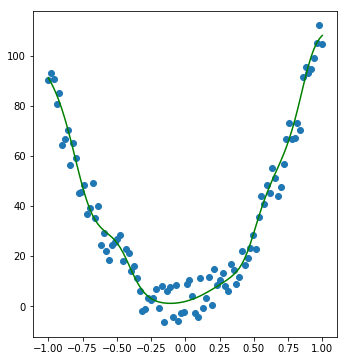

In [14]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!

#Solucao do instrutor
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh, weights_initializer=random_uniform))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh, weights_initializer=glorot_normal, biases_initializer=random_uniform))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear, weights_initializer=glorot_uniform))


#Minha solução
#nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
#nn.layers.append(Layer(input_dim=input_dim, output_dim=5, activation=relu))
#nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
#nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
#nn.layers.append(Layer(input_dim=5, output_dim=output_dim, activation=linear))



nn.fit(x, y, epochs=5000, verbose=500)
#print(nn.layers[0].weights)
#print(nn.layers[0].biases)
#print(nn.layers[1].weights)
#print(nn.layers[1].biases)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

(100, 1) (100, 1)


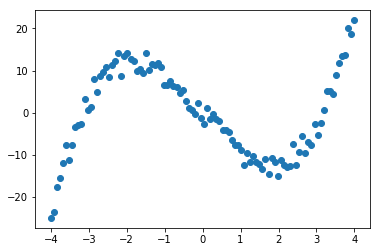

In [25]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [26]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 - loss_train: 59.84365792
Epoch:  500/5000 - loss_train: 29.94283001
Epoch: 1000/5000 - loss_train: 24.84693691
Epoch: 1500/5000 - loss_train: 14.91429429
Epoch: 2000/5000 - loss_train: 8.33551044
Epoch: 2500/5000 - loss_train: 5.59638387
Epoch: 3000/5000 - loss_train: 4.40488857
Epoch: 3500/5000 - loss_train: 3.87738957
Epoch: 4000/5000 - loss_train: 3.24136929
Epoch: 4500/5000 - loss_train: 3.16902364
Epoch: 5000/5000 - loss_train: 2.98546555


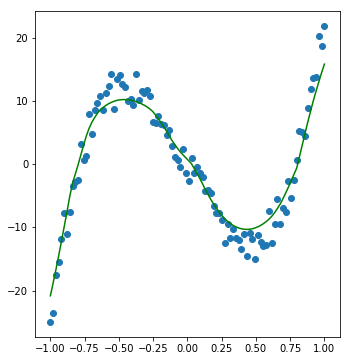

In [33]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=50, activation=relu, dropout_prob=0.5))
#nn.layers.append(Layer(input_dim=5, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=50, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

(100, 1) (100, 1)


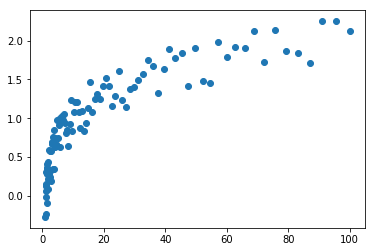

In [114]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)
plt.scatter(x, y)

In [115]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/5000 - loss_train: 0.70182996
Epoch:  500/5000 - loss_train: 0.07045369
Epoch: 1000/5000 - loss_train: 0.05838385
Epoch: 1500/5000 - loss_train: 0.04940415
Epoch: 2000/5000 - loss_train: 0.04301873
Epoch: 2500/5000 - loss_train: 0.03859136
Epoch: 3000/5000 - loss_train: 0.03550098
Epoch: 3500/5000 - loss_train: 0.03328598
Epoch: 4000/5000 - loss_train: 0.03164464
Epoch: 4500/5000 - loss_train: 0.03038836
Epoch: 5000/5000 - loss_train: 0.02939914


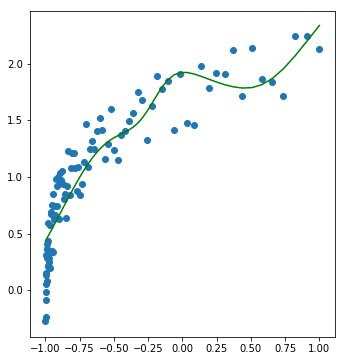

In [117]:
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
#nn.layers.append(Layer(input_dim=10, output_dim=5, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=5000, verbose=500)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

(100, 1) (100, 1)


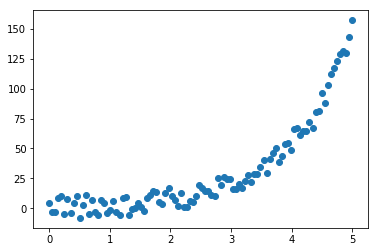

In [118]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)
plt.scatter(x, y)

In [119]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


Epoch:    0/20000 - loss_train: 1272.51619911
Epoch:  500/20000 - loss_train: 17.77130108
Epoch: 1000/20000 - loss_train: 16.23152718
Epoch: 1500/20000 - loss_train: 15.50034014
Epoch: 2000/20000 - loss_train: 15.13906155
Epoch: 2500/20000 - loss_train: 14.62904245
Epoch: 3000/20000 - loss_train: 14.39084230
Epoch: 3500/20000 - loss_train: 14.29886256
Epoch: 4000/20000 - loss_train: 14.27570119
Epoch: 4500/20000 - loss_train: 14.26731439
Epoch: 5000/20000 - loss_train: 14.26415746
Epoch: 5500/20000 - loss_train: 14.26136503
Epoch: 6000/20000 - loss_train: 14.26008074
Epoch: 6500/20000 - loss_train: 14.25914313
Epoch: 7000/20000 - loss_train: 14.25805065
Epoch: 7500/20000 - loss_train: 14.25713461
Epoch: 8000/20000 - loss_train: 14.25598847
Epoch: 8500/20000 - loss_train: 14.24957464
Epoch: 9000/20000 - loss_train: 14.24820209
Epoch: 9500/20000 - loss_train: 14.24637744
Epoch: 10000/20000 - loss_train: 14.24496175
Epoch: 10500/20000 - loss_train: 14.24368412
Epoch: 11000/20000 - loss_tr

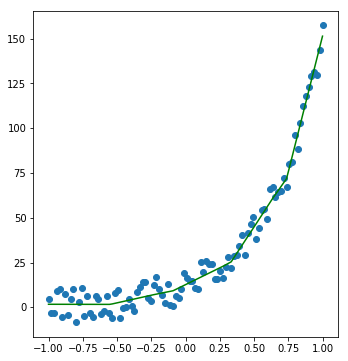

In [132]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
#nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=20000, verbose=500)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

(4, 2) (4, 1)


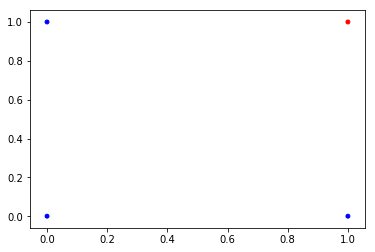

In [26]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/1000 - loss_train: 1.61416566
Epoch:  100/1000 - loss_train: 0.15439870
Epoch:  200/1000 - loss_train: 0.08508718
Epoch:  300/1000 - loss_train: 0.05818792
Epoch:  400/1000 - loss_train: 0.04401023
Epoch:  500/1000 - loss_train: 0.03530438
Epoch:  600/1000 - loss_train: 0.02943417
Epoch:  700/1000 - loss_train: 0.02521660
Epoch:  800/1000 - loss_train: 0.02204399
Epoch:  900/1000 - loss_train: 0.01957296
Epoch: 1000/1000 - loss_train: 0.01759521
Predições:
[[1.28424136e-05]
 [2.04451893e-02]
 [2.04451921e-02]
 [9.71364190e-01]]
Acurácia: 100.00%


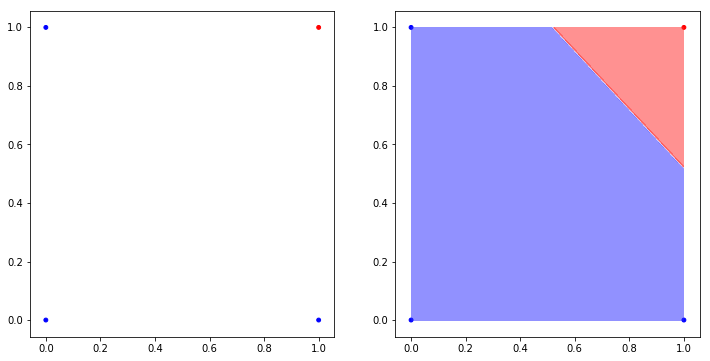

In [28]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=sigmoid))


#nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
#nn.layers.append(Layer(input_dim=input_dim, output_dim=output_dim, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)
y_pred = nn.predict(x)

print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, threshold=0.5,  nn=nn, cmap='bwr')

### Porta XOR

(4, 2) (4, 1)


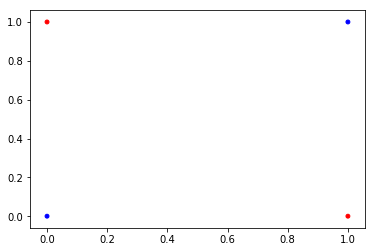

In [16]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/1000 - loss_train: 0.79134795
Epoch:  500/1000 - loss_train: 0.15931010
Epoch: 1000/1000 - loss_train: 0.01926932
Predições:
[[0.01446033]
 [0.98279578]
 [0.98289978]
 [0.02752348]]
Acurácia: 100.00%


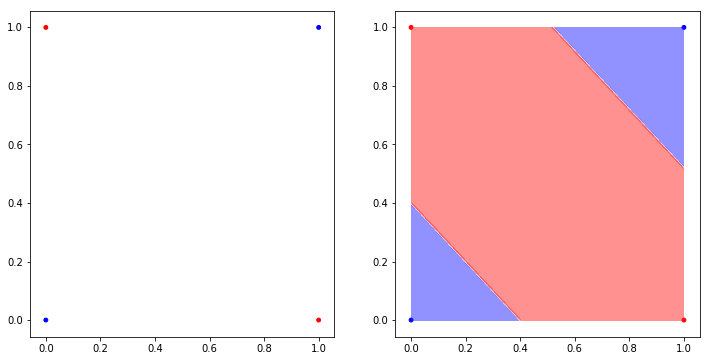

In [22]:
input_dim, output_dim = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=500)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, threshold=0.5, nn=nn, cmap='bwr')

### 2 Clusters

(100, 2) (100, 1)


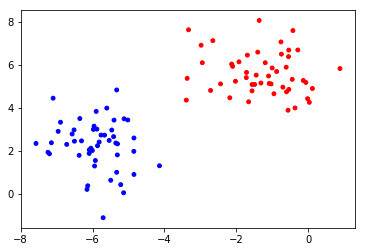

In [29]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/1000 - loss_train: 0.02585477
Epoch:  100/1000 - loss_train: 0.00390590
Epoch:  200/1000 - loss_train: 0.00328019
Epoch:  300/1000 - loss_train: 0.00286115
Epoch:  400/1000 - loss_train: 0.00255458
Epoch:  500/1000 - loss_train: 0.00231747
Epoch:  600/1000 - loss_train: 0.00212694
Epoch:  700/1000 - loss_train: 0.00196951
Epoch:  800/1000 - loss_train: 0.00183663
Epoch:  900/1000 - loss_train: 0.00172257
Epoch: 1000/1000 - loss_train: 0.00162333
Acurácia: 100.00%


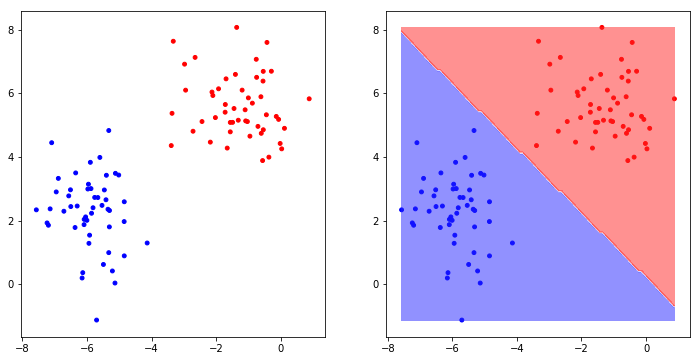

In [33]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=1, activation=sigmoid))
#nn.layers.append(Layer(input_dim=1, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)
y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

(500, 2) (500, 1)


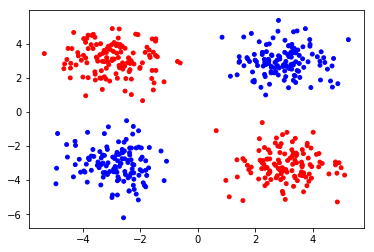

In [34]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/1000 - loss_train: 0.47110247
Epoch:  100/1000 - loss_train: 0.01653549
Epoch:  200/1000 - loss_train: 0.00770701
Epoch:  300/1000 - loss_train: 0.00500492
Epoch:  400/1000 - loss_train: 0.00369541
Epoch:  500/1000 - loss_train: 0.00292369
Epoch:  600/1000 - loss_train: 0.00241560
Epoch:  700/1000 - loss_train: 0.00205620
Epoch:  800/1000 - loss_train: 0.00178872
Epoch:  900/1000 - loss_train: 0.00158203
Epoch: 1000/1000 - loss_train: 0.00141760
Acurácia: 100.00%


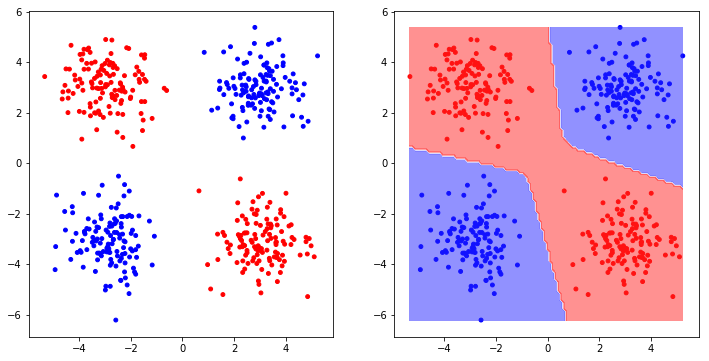

In [45]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

(500, 2) (500, 1)


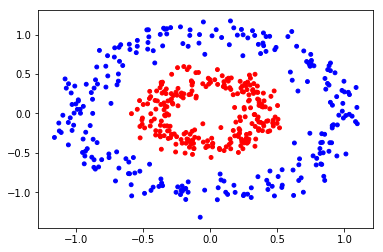

In [46]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/1000 - loss_train: 0.89730802
Epoch:  100/1000 - loss_train: 0.06607115
Epoch:  200/1000 - loss_train: 0.02884501
Epoch:  300/1000 - loss_train: 0.01908249
Epoch:  400/1000 - loss_train: 0.01456130
Epoch:  500/1000 - loss_train: 0.01191644
Epoch:  600/1000 - loss_train: 0.01015539
Epoch:  700/1000 - loss_train: 0.00886188
Epoch:  800/1000 - loss_train: 0.00786445
Epoch:  900/1000 - loss_train: 0.00707364
Epoch: 1000/1000 - loss_train: 0.00644088
Acurácia: 100.00%


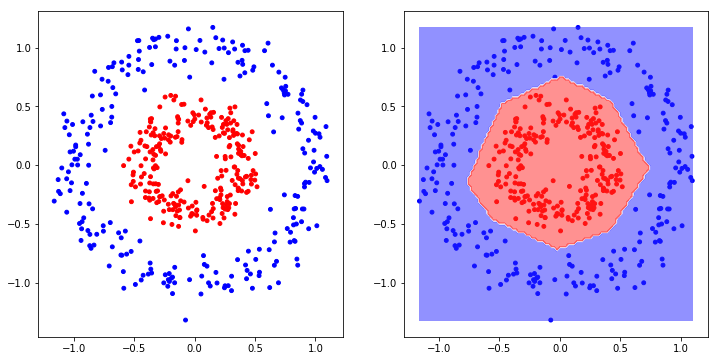

In [49]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

(200, 2) (200, 1)


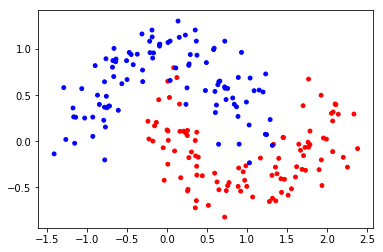

In [39]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/2000 - loss_train: 0.61812472
Epoch: 1000/2000 - loss_train: 0.27595776
Epoch: 2000/2000 - loss_train: 0.23438397
Acurácia: 92.50%


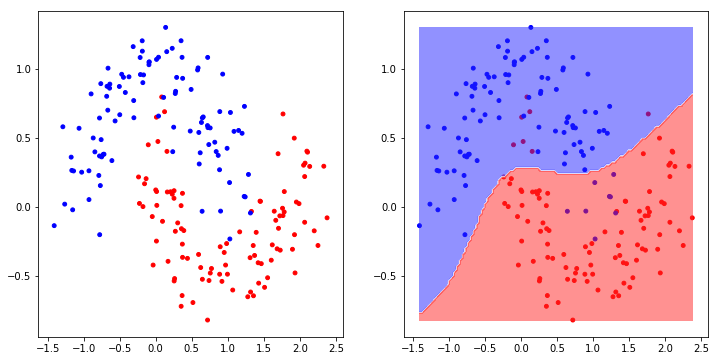

In [46]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=8, activation=tanh, reg_strength=1, reg_func=l2_regularization))
#nn.layers.append(Layer(input_dim=10, output_dim=, activation=tanh))
nn.layers.append(Layer(input_dim=8, output_dim=output_dim, activation=sigmoid, reg_strength=1, reg_func=l2_regularization))

nn.fit(x, y, epochs=2000, verbose=1000)
y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

(200, 2) (200, 1)


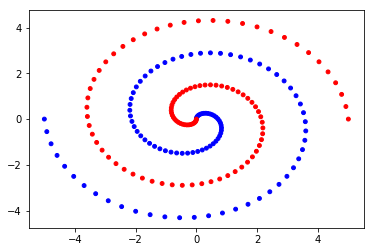

In [62]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap='bwr')

Epoch:    0/10000 - loss_train: 1.34700488
Epoch: 1000/10000 - loss_train: 0.16405745
Epoch: 2000/10000 - loss_train: 0.05590765
Epoch: 3000/10000 - loss_train: 0.03112079
Epoch: 4000/10000 - loss_train: 0.02216985
Epoch: 5000/10000 - loss_train: 0.01787452
Epoch: 6000/10000 - loss_train: 0.01538867
Epoch: 7000/10000 - loss_train: 0.01376713
Epoch: 8000/10000 - loss_train: 0.01261327
Epoch: 9000/10000 - loss_train: 0.01173640
Epoch: 10000/10000 - loss_train: 0.01105616
Acurácia: 99.50%


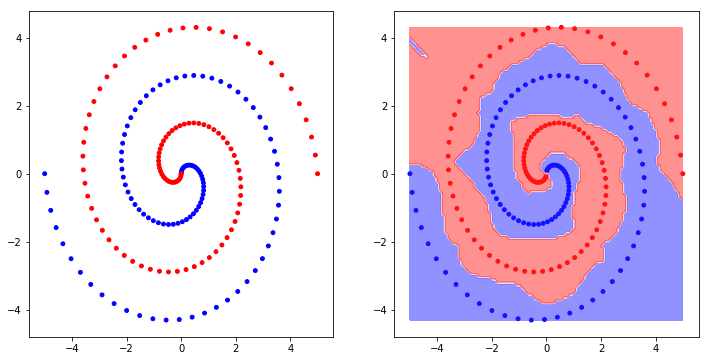

In [75]:
input_dim, output_dim = x.shape[1], y.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
#nn.layers.append(Layer(input_dim=20, output_dim=10, activation=tanh))
#nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=sigmoid))

nn.fit(x, y, epochs=10000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plot.classification_predictions(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

(300, 2) (300, 1)


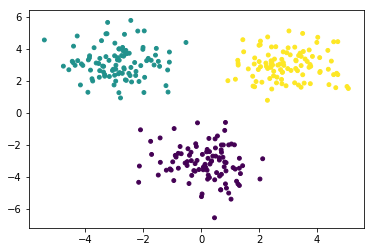

In [76]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [77]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


Epoch:    0/1000 - loss_train: 0.53242720
Epoch:  200/1000 - loss_train: 0.04843040
Epoch:  400/1000 - loss_train: 0.02413928
Epoch:  600/1000 - loss_train: 0.01582689
Epoch:  800/1000 - loss_train: 0.01169882
Epoch: 1000/1000 - loss_train: 0.00924128
Acurácia: 100.00%


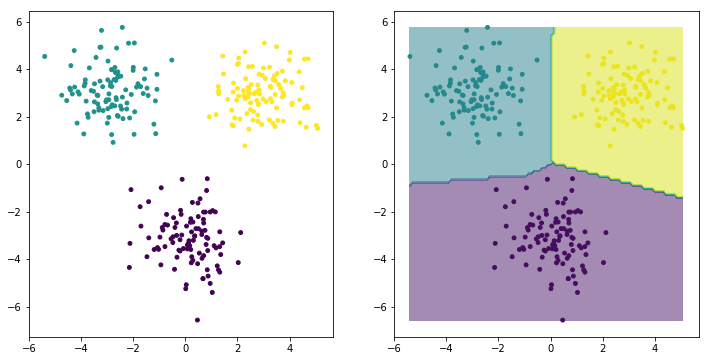

In [88]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!


nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=200)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

(400, 2) (400, 1)


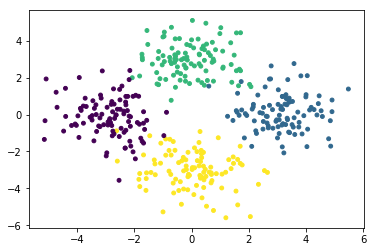

In [89]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [90]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


Epoch:    0/1000 - loss_train: 2.41935597
Epoch:  200/1000 - loss_train: 0.36287394
Epoch:  400/1000 - loss_train: 0.14563571
Epoch:  600/1000 - loss_train: 0.11069820
Epoch:  800/1000 - loss_train: 0.09897260
Epoch: 1000/1000 - loss_train: 0.09333522
Acurácia: 97.25%


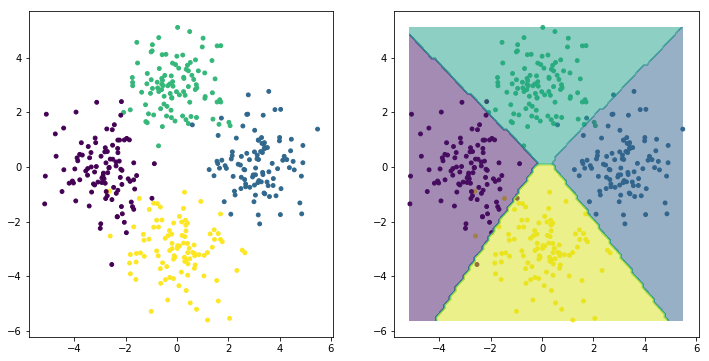

In [94]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

(500, 2) (500, 1)


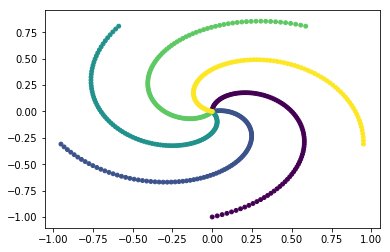

In [95]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [96]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


Epoch:    0/2000 - loss_train: 2.70564754
Epoch:  200/2000 - loss_train: 0.93034782
Epoch:  400/2000 - loss_train: 0.61530241
Epoch:  600/2000 - loss_train: 0.50943704
Epoch:  800/2000 - loss_train: 0.34477122
Epoch: 1000/2000 - loss_train: 0.24863579
Epoch: 1200/2000 - loss_train: 0.19285802
Epoch: 1400/2000 - loss_train: 0.15798486
Epoch: 1600/2000 - loss_train: 0.13476209
Epoch: 1800/2000 - loss_train: 0.11833624
Epoch: 2000/2000 - loss_train: 0.10604808
Acurácia: 97.60%


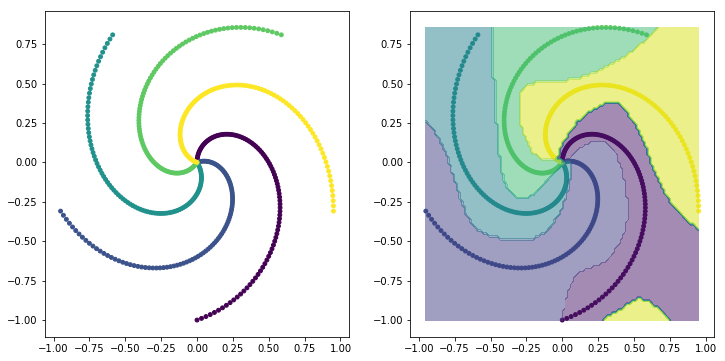

In [103]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=6, activation=tanh))
nn.layers.append(Layer(input_dim=6, output_dim=6, activation=tanh))
nn.layers.append(Layer(input_dim=6, output_dim=6, activation=tanh))
nn.layers.append(Layer(input_dim=6, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)


y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

(100, 2) (100, 1)


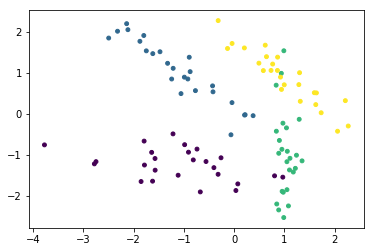

In [104]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [105]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


Epoch:    0/2000 - loss_train: 2.11071780
Epoch:  200/2000 - loss_train: 0.20656803
Epoch:  400/2000 - loss_train: 0.17009516
Epoch:  600/2000 - loss_train: 0.15166431
Epoch:  800/2000 - loss_train: 0.14208799
Epoch: 1000/2000 - loss_train: 0.13588648
Epoch: 1200/2000 - loss_train: 0.13108105
Epoch: 1400/2000 - loss_train: 0.12699144
Epoch: 1600/2000 - loss_train: 0.12331090
Epoch: 1800/2000 - loss_train: 0.11988461
Epoch: 2000/2000 - loss_train: 0.11666845
Acurácia: 95.00%


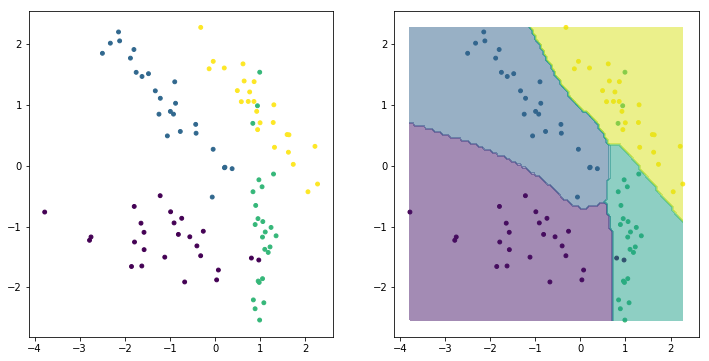

In [110]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

# insira sua rede aqui!

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=20, activation=tanh))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
#nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

### Iris Dataset

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


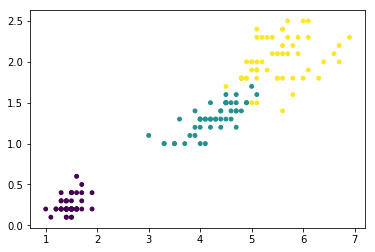

In [18]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)
plt.scatter(x[:,0], x[:,1], c=list(np.array(y).ravel()), s=15, cmap=plt.cm.viridis)

In [19]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Epoch:    0/4000 - loss_train: 0.55906727
Epoch:  200/4000 - loss_train: 0.10525941
Epoch:  400/4000 - loss_train: 0.10027839
Epoch:  600/4000 - loss_train: 0.08270151
Epoch:  800/4000 - loss_train: 0.10017994
Epoch: 1000/4000 - loss_train: 0.11218355
Epoch: 1200/4000 - loss_train: 0.07268237
Epoch: 1400/4000 - loss_train: 0.07088456
Epoch: 1600/4000 - loss_train: 0.09254156
Epoch: 1800/4000 - loss_train: 0.07138208
Epoch: 2000/4000 - loss_train: 0.07474881
Epoch: 2200/4000 - loss_train: 0.11431668
Epoch: 2400/4000 - loss_train: 0.07279765
Epoch: 2600/4000 - loss_train: 0.06491215
Epoch: 2800/4000 - loss_train: 0.10242312
Epoch: 3000/4000 - loss_train: 0.08089937
Epoch: 3200/4000 - loss_train: 0.06157406
Epoch: 3400/4000 - loss_train: 0.06628389
Epoch: 3600/4000 - loss_train: 0.09225089
Epoch: 3800/4000 - loss_train: 0.05985511
Epoch: 4000/4000 - loss_train: 0.06390621
Acurácia: 96.00%


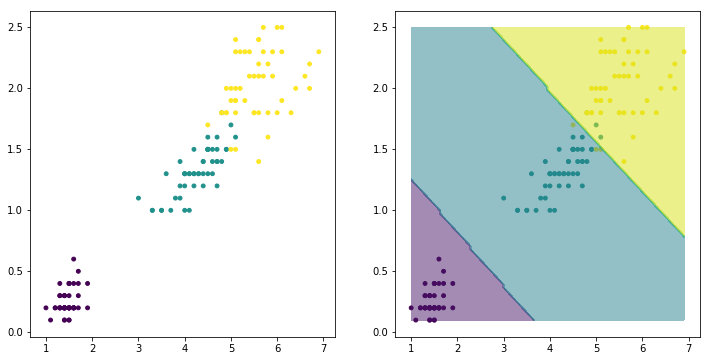

In [21]:
input_dim, output_dim = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=input_dim, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=output_dim, activation=linear))

nn.fit(x, y_onehot, epochs=4000, verbose=200, batch_gen=batch_shuffle, batch_size=15)
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plot.classification_predictions(x, y, is_binary=False, nn=nn)

# [Link para o Questionário](https://docs.google.com/forms/d/e/1FAIpQLSf1B3JKsPPPc1oYD_3FyX4UvNLpcXnTW2I177A_WE0_B56Elw/viewform?usp=sf_link)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)